In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import json
from tqdm import tqdm

# --- Encoder ---
class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        self.enc_image_size = encoded_image_size
        self.encoder_dim = 2048

        resnet = models.resnet101(weights='DEFAULT')
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fine_tune()

    def forward(self, images):
        out = self.resnet(images)
        out = self.adaptive_pool(out)
        out = out.permute(0, 2, 3, 1)  # (B, 14, 14, 2048)
        out = out.view(out.size(0), -1, out.size(-1))  # (B, num_pixels, 2048)
        return out

    def fine_tune(self, fine_tune=True):
        for p in self.resnet.parameters():
            p.requires_grad = False
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

# --- Decoder ---
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, encoder_dim=2048, dropout=0.5,
                 pretrained_embeddings=None, freeze_embeddings=False):
        super(DecoderRNN, self).__init__()
        self.encoder_dim = encoder_dim
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embed_size)
        if pretrained_embeddings is not None:
            self.embedding.weight = nn.Parameter(pretrained_embeddings)
            self.embedding.weight.requires_grad = not freeze_embeddings
        else:
            self.embedding.weight.data.uniform_(-0.1, 0.1)

        self.dropout = nn.Dropout(p=dropout)
        self.init_h = nn.Linear(encoder_dim, hidden_size)
        self.init_c = nn.Linear(encoder_dim, hidden_size)
        self.lstm = nn.LSTMCell(embed_size + encoder_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, captions, caplens):
        batch_size = encoder_out.size(0)
        encoder_out = encoder_out.view(batch_size, -1, self.encoder_dim)
        caplens, sort_ind = caplens.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        captions = captions[sort_ind]
        embeddings = self.embedding(captions)

        h, c = self.init_hidden_state(encoder_out)
        decode_lengths = (caplens - 1).tolist()
        predictions = torch.zeros(batch_size, max(decode_lengths), self.vocab_size).to(encoder_out.device)

        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            awe = encoder_out[:batch_size_t].mean(dim=1)
            input_lstm = torch.cat([embeddings[:batch_size_t, t, :], awe], dim=1)
            h, c = self.lstm(input_lstm, (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds

        return predictions, captions, decode_lengths, sort_ind

In [2]:
!pip install openai

In [3]:
import os, json, torch
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
import time
from openai import OpenAIError, RateLimitError
from openai import OpenAI

# --- Config ---
client = OpenAI(api_key="API KEY")

aspects = [
    "color_light", "composition", "dof_and_focus",
    "general_impression", "subject", "use_of_camera"
]

dataset_path = "/kaggle/input/food-iac-fine-tune-dataset/final/all.json"
image_folder = "/kaggle/input/dpchallenge-images-food-gallery/images"
ckpt_dir2 = "/kaggle/input/single-aspects-part-2/pytorch/default/2/fine-tuned-models"
ckpt_dir1 = "/kaggle/input/single-aspects/pytorch/default/3/fine-tuned-models"
word_map_path = "/kaggle/input/food-iac-fine-tune-dataset/preprocessed_dataset/wordmap_all.json"
output_file = "/kaggle/working/retouched_captions.jsonl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# --- Load word_map ---
with open(word_map_path) as f:
    word_map = json.load(f)
rev_word_map = {v: k for k, v in word_map.items()}

# --- Load dataset ---
with open(dataset_path) as f:
    all_data = json.load(f)
test_images = [item for item in all_data['images'] if item['split'] == 'test']

import random
random.seed(42)

# Ambil 10 gambar acak dari test set
sampled_images = random.sample(test_images, k=10)

In [15]:
import base64
import random
import json, os
from IPython.display import display, Image as IPyImage

# --- Helper: Image to Base64 ---
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")

# --- Prompt with image ---
def build_visual_retouch_prompt(caption, image_base64):
    return [
        {
            "role": "system",
            "content": "You are a professional food photography critic. Your task is to rewrite a food photo caption to make it more fluent, natural, and visually descriptive, while preserving the original meaning and tone."
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"""This caption was generated by a machine. It may contain <unk> tokens or unnatural phrasing.

Your job:
- Fix grammar, punctuation, and fluency.
- Replace <unk> with appropriate words using the image as reference.
- Preserve original meaning and intent.

Caption: {caption}

Return only the improved caption."""
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_base64}"
                    }
                }
            ]
        }
    ]

# --- Retouch with GPT-4o-mini + image ---
def retouch_caption_with_gpt_visual(caption, image_path, retry_delay=10):
    base64_image = image_to_base64(image_path)

    def try_visual_call():
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=build_visual_retouch_prompt(caption, base64_image),
                max_tokens=100,
                temperature=0.7
            )
            return response.choices[0].message.content.strip()
        except RateLimitError:
            print("⏳ Rate limit reached. Retrying after delay...")
            time.sleep(retry_delay)
            return try_visual_call()
        except Exception as e:
            print(f"⚠️ Gagal upload image untuk {image_path}. Menggunakan retouch text-only. Alasan: {e}")
            return None

    # --- Try visual retouch
    visual_result = try_visual_call()
    if visual_result:
        return visual_result

    # --- Fallback to text-only retouch
    def try_text_only():
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant who improves captions."},
                    {"role": "user", "content": f"""This caption was generated by a machine. It may contain <unk> tokens or awkward phrasing.

Please rewrite it fluently while preserving the meaning.

Caption: {caption}

Return only the improved caption."""}
                ],
                max_tokens=100,
                temperature=0.7
            )
            return response.choices[0].message.content.strip()
        except RateLimitError:
            print("⏳ Rate limit (text-only) reached. Retrying...")
            time.sleep(retry_delay)
            return try_text_only()
        except Exception as e:
            print(f"❌ Text-only fallback also failed: {e}")
            return "[GPT ERROR]"

    return try_text_only()

In [12]:
def build_batch_retouch_prompt(caption_dict, image_base64):
    """
    caption_dict: dict of aspect -> generated caption
    image_base64: image in base64 format (JPEG)
    """
    # Build the text prompt
    text_parts = [
        "You are a professional food photography critic. Each caption below was generated by a machine and may contain <unk> tokens or awkward phrasing.\n",
        "Your job:\n"
        "- Improve grammar, punctuation, and fluency.\n"
        "- Replace <unk> using the image as context.\n"
        "- Preserve the original meaning of each caption.\n\n"
        "Rewrite all the captions, and return them as a JSON dictionary where the keys are aspect names and the values are the retouched captions.\n\n",
        "Captions to retouch:"
    ]
    
    for aspect, caption in caption_dict.items():
        text_parts.append(f"- {aspect}: {caption}")

    full_prompt = "\n".join(text_parts)

    return [
        {
            "role": "system",
            "content": "You are a professional food photography caption editor. Use the provided image to enhance the captions below."
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": full_prompt
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_base64}"
                    }
                }
            ]
        }
    ]

In [7]:
def caption_image_beam_search(encoder, decoder, image, word_map, beam_size=5, max_len=25, unk_penalty_weight=0.5):
    k = beam_size
    vocab_size = len(word_map)
    rev_word_map = {v: k for k, v in word_map.items()}
    unk_idx = word_map['<unk>']

    encoder_out = encoder(image.unsqueeze(0))  # (1, num_pixels, encoder_dim)
    encoder_dim = encoder_out.size(-1)
    encoder_out = encoder_out.expand(k, -1, encoder_dim)

    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)
    seqs = k_prev_words
    top_k_scores = torch.zeros(k, 1).to(device)

    complete_seqs = []
    complete_seqs_scores = []

    h, c = decoder.init_hidden_state(encoder_out)

    step = 1
    while True:
        embeddings = decoder.embedding(k_prev_words).squeeze(1)
        awe = encoder_out.mean(dim=1)  # mean attention
        input_lstm = torch.cat([embeddings, awe], dim=1)
        h, c = decoder.lstm(input_lstm, (h, c))
        scores = decoder.fc(h)
        scores = F.log_softmax(scores, dim=1)

        scores = top_k_scores.expand_as(scores) + scores
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
        else:
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)

        prev_word_inds = top_k_words // vocab_size
        next_word_inds = top_k_words % vocab_size

        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)

        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])

        k -= len(complete_inds)
        if k == 0 or step > max_len:
            break

        seqs = seqs[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        step += 1

    if len(complete_seqs) == 0:
        best_seq = seqs[0].tolist()
    else:
        # Penalize scores by UNK count
        penalized_scores = [
            score - unk_penalty_weight * seq.count(unk_idx)
            for seq, score in zip(complete_seqs, complete_seqs_scores)
        ]
        best_index = penalized_scores.index(max(penalized_scores))
        best_seq = complete_seqs[best_index]

    decoded = [rev_word_map[idx] for idx in best_seq if idx not in {word_map['<start>'], word_map['<pad>'], word_map['<end>']}]
    return decoded

In [8]:
# --- Load Gambar ---
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)

In [9]:
# --- Load Model ---
def load_model_for_aspect(aspect):
    if aspect in ["color_light", "composition", "dof_and_focus"]:
        ckpt_dir = ckpt_dir1
    else:
        ckpt_dir = ckpt_dir2

    checkpoint_path = os.path.join(ckpt_dir, f"{aspect}_best.pth")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    encoder = EncoderCNN().to(device)
    decoder = DecoderRNN(
        embed_size=300,
        hidden_size=512,
        vocab_size=len(word_map),
        pretrained_embeddings=None
    ).to(device)

    encoder.load_state_dict(checkpoint["encoder"])
    decoder.load_state_dict(checkpoint["decoder"])
    encoder.eval()
    decoder.eval()
    return encoder, decoder


🔍 Running retouch for: 380579.jpg


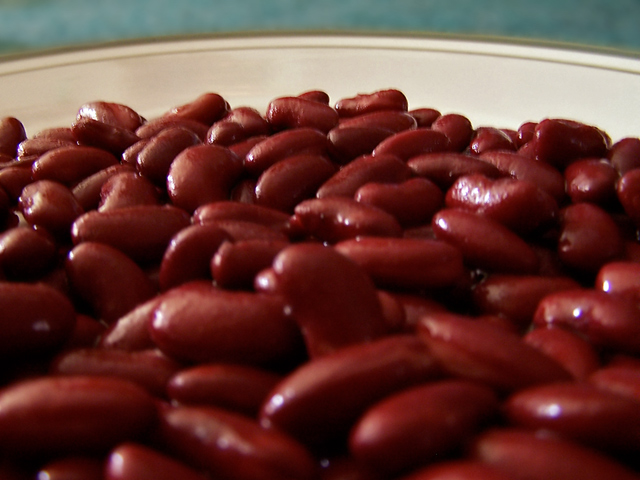


🧩 COLOR_LIGHT
📜 Original:  this is a bit too dark
✨ Retouched: This image is a bit too dark.

🧩 COMPOSITION
📜 Original:  nice composition and i like the colors and the background is a little distracting
✨ Retouched: The composition is appealing, and I appreciate the vibrant colors; however, the background is somewhat distracting.

🧩 DOF_AND_FOCUS
📜 Original:  i like the colors and the light is a little soft
✨ Retouched: I love the vibrant colors, and the soft lighting adds a gentle touch.

🧩 GENERAL_IMPRESSION
📜 Original:  i like the colors in this photo great job
✨ Retouched: I love the rich colors in this photo—great job!

🧩 SUBJECT
📜 Original:  this is a nice shot
✨ Retouched: This is a beautiful close-up of glossy red kidney beans, showcasing their rich color and smooth texture.

🧩 USE_OF_CAMERA
📜 Original:  all looks on the lighting
✨ Retouched: All eyes are drawn to the lighting.

🔍 Running retouch for: 952321.jpg


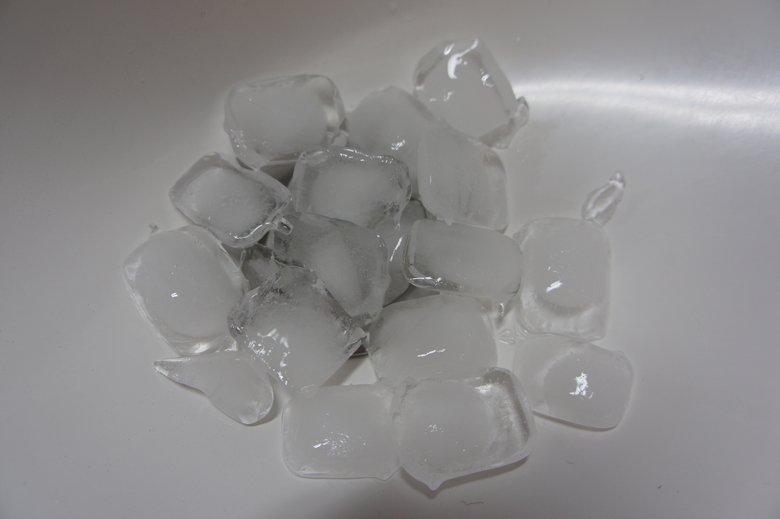


🧩 COLOR_LIGHT
📜 Original:  excellent lighting and dof
✨ Retouched: The lighting and depth of field are excellent.

🧩 COMPOSITION
📜 Original:  nice composition and composition good composition
✨ Retouched: A beautifully arranged composition of clear ice cubes, glistening in the light.

🧩 DOF_AND_FOCUS
📜 Original:  seems a little soft focus
✨ Retouched: The image has a slightly soft focus.

🧩 GENERAL_IMPRESSION
📜 Original:  a very nice picture but i like the idea
✨ Retouched: A beautifully captured image, and I really appreciate the concept behind it.

🧩 SUBJECT
📜 Original:  nice still life i like the <unk> of the glass
✨ Retouched: Nice still life! I love the clarity of the ice cubes.

🧩 USE_OF_CAMERA
📜 Original:  i like the something like something
✨ Retouched: I love the refreshing chill of ice cubes.

🔍 Running retouch for: 135258.jpg


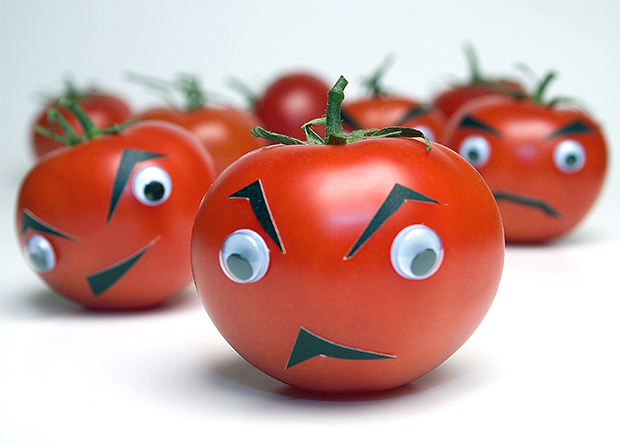


🧩 COLOR_LIGHT
📜 Original:  i like the lighting is a bit harsh
✨ Retouched: I think the lighting is a bit harsh.

🧩 COMPOSITION
📜 Original:  nice composition and lighting is a little distracting
✨ Retouched: The composition is appealing, but the lighting is somewhat distracting.

🧩 DOF_AND_FOCUS
📜 Original:  this image is a little too much of this image is a little dark for me
✨ Retouched: This image feels a bit too dark for my taste.

🧩 GENERAL_IMPRESSION
📜 Original:  good idea and well done
✨ Retouched: Great concept, well executed!

🧩 SUBJECT
📜 Original:  very nice still life i like the colors are very nice shot
✨ Retouched: This charming still life features vibrant colors that create a delightful visual impact.

🧩 USE_OF_CAMERA
📜 Original:  i like something like the <unk> of the <unk> <unk> <unk>
✨ Retouched: I like something like the playful expressions of these quirky, animated tomatoes.

🔍 Running retouch for: 278457.jpg


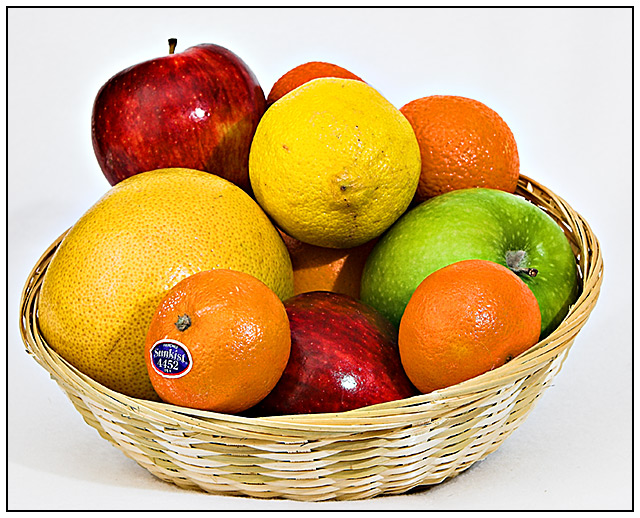

⏳ Rate limit reached. Retrying after delay...

🧩 COLOR_LIGHT
📜 Original:  very nice lighting and colors are a bit harsh
✨ Retouched: The lighting is lovely, but the colors appear a bit harsh.

🧩 COMPOSITION
📜 Original:  i like the composition and the composition is a little distracting
✨ Retouched: I appreciate the composition, but it feels slightly distracting.

🧩 DOF_AND_FOCUS
📜 Original:  i like the idea of this image would have been better if you were in focus
✨ Retouched: I love the concept of this image; it would be even better if the focus were sharper.

🧩 GENERAL_IMPRESSION
📜 Original:  a good idea but i like the idea
✨ Retouched: A great concept, and I really appreciate the idea!

🧩 SUBJECT
📜 Original:  i like the colors on the subject
✨ Retouched: I love the vibrant colors of the fruits in the basket.

🧩 USE_OF_CAMERA
📜 Original:  i like the the <unk> and the <unk> and something
✨ Retouched: I love the vibrant apples and the juicy citrus fruits in this beautiful basket.

🔍 Ru

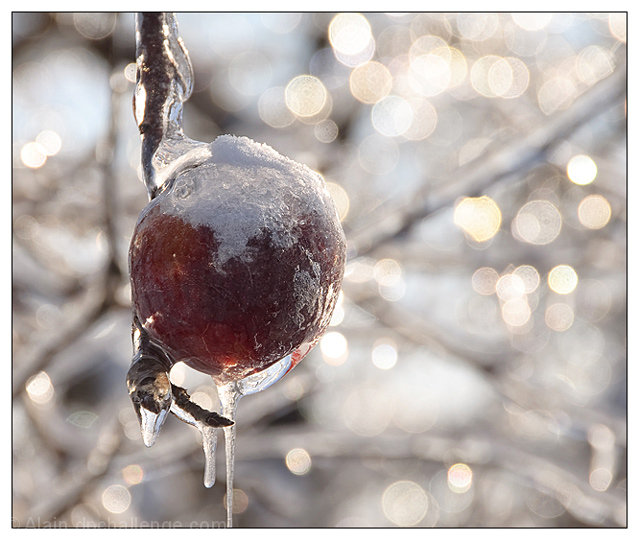

⏳ Rate limit reached. Retrying after delay...
⏳ Rate limit reached. Retrying after delay...
⏳ Rate limit reached. Retrying after delay...

🧩 COLOR_LIGHT
📜 Original:  the lighting is a bit harsh
✨ Retouched: The lighting is a bit intense.

🧩 COMPOSITION
📜 Original:  i like this shot i like the colors and composition
✨ Retouched: I really love this shot; the colors and composition are stunning.

🧩 DOF_AND_FOCUS
📜 Original:  nice colors and the focus is a little soft focus
✨ Retouched: The vibrant colors shine beautifully, and the focus has a gentle, soft quality.

🧩 GENERAL_IMPRESSION
📜 Original:  nice idea i like the lighting and the background is a bit distracting
✨ Retouched: I love the concept! The lighting is beautiful, but the background feels a bit distracting.

🧩 SUBJECT
📜 Original:  the subject is nice shot but i like the top of the glass
✨ Retouched: The subject is a beautiful shot, but I particularly love the top of the glass.

🧩 USE_OF_CAMERA
📜 Original:  this is something li

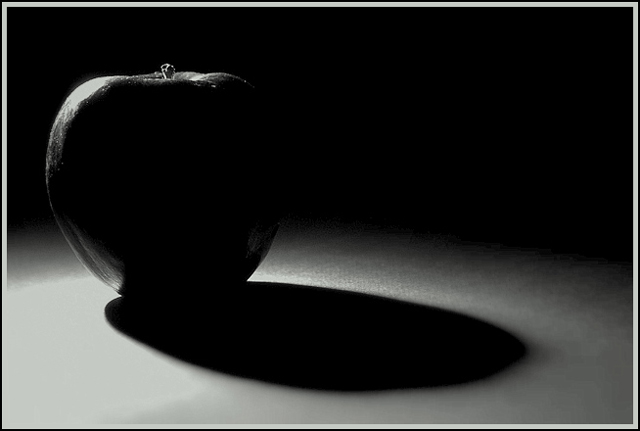

⏳ Rate limit reached. Retrying after delay...

🧩 COLOR_LIGHT
📜 Original:  great use of the <unk>
✨ Retouched: Great use of the apple.

🧩 COMPOSITION
📜 Original:  nice composition and i like the composition
✨ Retouched: The composition is striking, and I truly appreciate its elegance.

🧩 DOF_AND_FOCUS
📜 Original:  nice job
✨ Retouched: Well done!

🧩 GENERAL_IMPRESSION
📜 Original:  i love this photo is a nice idea but i would have liked to see a little more of focus
✨ Retouched: I love this photo; it’s a great concept, but I would have preferred a bit more focus.

🧩 SUBJECT
📜 Original:  i would have been better if it would have been a bit more of the glass
✨ Retouched: It would have been better if there had been a bit more glass in the composition.

🧩 USE_OF_CAMERA
📜 Original:  this is something like something like the camera in the challenge
✨ Retouched: This is reminiscent of the camera used in the challenge.

🔍 Running retouch for: 803166.jpg


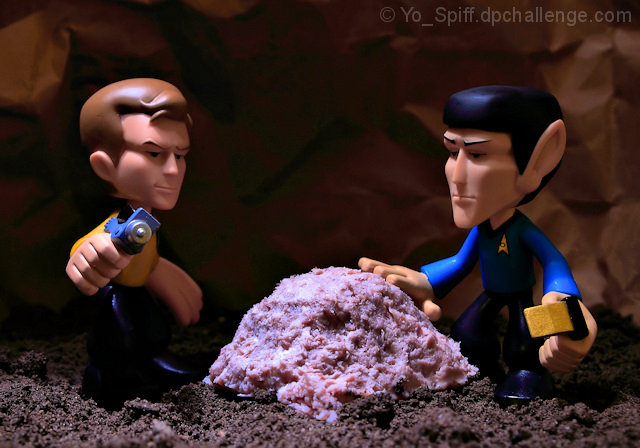

⏳ Rate limit reached. Retrying after delay...

🧩 COLOR_LIGHT
📜 Original:  good use of dof i like the lighting is a bit harsh
✨ Retouched: Great use of depth of field! I like the composition, although the lighting feels a bit harsh.

🧩 COMPOSITION
📜 Original:  this is a lot of interest in this shot i think this would have been better on the top left corner of the left of the
✨ Retouched: There's a lot of intrigue in this shot. I believe it would have been more effective positioned in the top left corner.

🧩 DOF_AND_FOCUS
📜 Original:  i like this image i like this image
✨ Retouched: I really enjoy this image.

🧩 GENERAL_IMPRESSION
📜 Original:  not sure what this is a great photo
✨ Retouched: Not quite sure what this is, but it's a great photo!

🧩 SUBJECT
📜 Original:  this is a very nice shot
✨ Retouched: This is a wonderfully captivating scene.

🧩 USE_OF_CAMERA
📜 Original:  i like the camera and the challenge of the challenge of the <unk>
✨ Retouched: I enjoy the camera and the thrill of

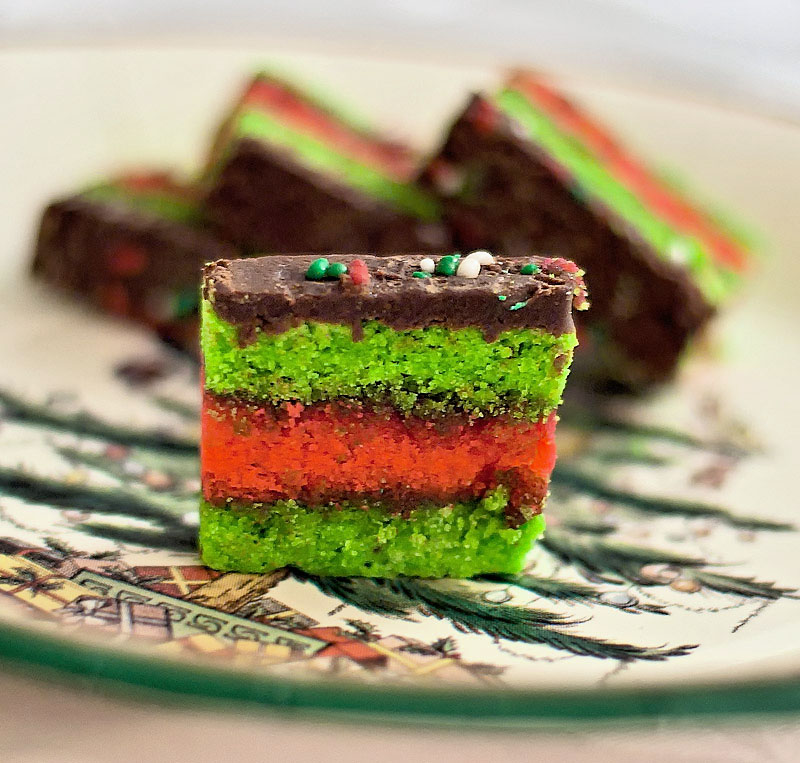

⚠️ Gagal upload image untuk /kaggle/input/dpchallenge-images-food-gallery/images/926965.jpg. Menggunakan retouch text-only. Alasan: Error code: 400 - {'error': {'message': 'You uploaded an unsupported image. Please make sure your image is valid.', 'type': 'invalid_request_error', 'param': None, 'code': 'image_parse_error'}}
⚠️ Gagal upload image untuk /kaggle/input/dpchallenge-images-food-gallery/images/926965.jpg. Menggunakan retouch text-only. Alasan: Error code: 400 - {'error': {'message': 'You uploaded an unsupported image. Please make sure your image is valid.', 'type': 'invalid_request_error', 'param': None, 'code': 'image_parse_error'}}
⚠️ Gagal upload image untuk /kaggle/input/dpchallenge-images-food-gallery/images/926965.jpg. Menggunakan retouch text-only. Alasan: Error code: 400 - {'error': {'message': 'You uploaded an unsupported image. Please make sure your image is valid.', 'type': 'invalid_request_error', 'param': None, 'code': 'image_parse_error'}}
⚠️ Gagal upload image 

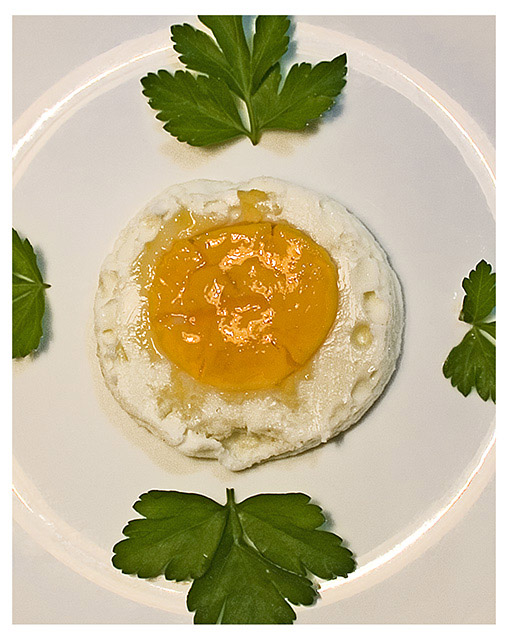


🧩 COLOR_LIGHT
📜 Original:  this is a bit too dark and focus
✨ Retouched: This image is a bit too dark and out of focus.

🧩 COMPOSITION
📜 Original:  i like the composition is a little distracting
✨ Retouched: I appreciate the composition, though it feels a bit distracting.

🧩 DOF_AND_FOCUS
📜 Original:  this image is a little too much for me but it is a little too much of focus on the bottom of the image is too
✨ Retouched: This dish may be a bit overwhelming for me, but the vibrant yolk at the center surrounded by delicate parsley leaves adds a lovely touch of focus to the presentation.

🧩 GENERAL_IMPRESSION
📜 Original:  i like the idea but i like the idea but i like the idea
✨ Retouched: I love the concept of this dish; it beautifully combines simplicity and elegance.

🧩 SUBJECT
📜 Original:  is a good shot
✨ Retouched: This is a delightful shot.

🧩 USE_OF_CAMERA
📜 Original:  i like the <unk> in the challenge of the <unk>
✨ Retouched: I enjoy the artistry in the challenge of creating t

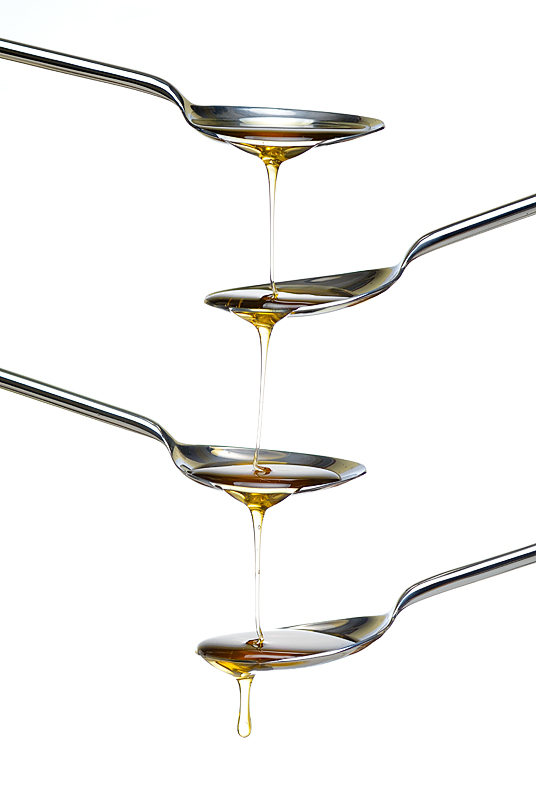

⏳ Rate limit reached. Retrying after delay...
⏳ Rate limit reached. Retrying after delay...

🧩 COLOR_LIGHT
📜 Original:  meets challenge technicalities interestingness out of the box personal bias total
✨ Retouched: This composition cleverly navigates the technicalities of food photography, showcasing a unique perspective that transcends personal bias and embraces creativity.

🧩 COMPOSITION
📜 Original:  i like this shot i like the composition
✨ Retouched: I really love this shot; the composition is fantastic!

🧩 DOF_AND_FOCUS
📜 Original:  i like the idea of the image
✨ Retouched: I love the concept captured in this image.

🧩 GENERAL_IMPRESSION
📜 Original:  nice idea but i think it would have been better if it was a good idea
✨ Retouched: Great concept, but it could have been executed even better.

🧩 SUBJECT
📜 Original:  this is a good shot i like the colors and the glass is very nice shot
✨ Retouched: This is a fantastic shot! I love the vibrant colors, and the way the liquid flows thro

In [13]:
# --- Run per image ---
for selected_image in sampled_images:
    image_path = os.path.join(image_folder, selected_image["filename"])
    image_tensor = preprocess_image(image_path)

    print(f"\n🔍 Running retouch for: {selected_image['filename']}")
    display(IPyImage(filename=image_path))

    results = []
    for aspect in aspects:
        encoder, decoder = load_model_for_aspect(aspect)
        tokens = caption_image_beam_search(encoder, decoder, image_tensor.squeeze(0), word_map)
        original_caption = " ".join(tokens)
        
        retries = 3
        for attempt in range(retries):
            try:
                retouched = retouch_caption_with_gpt_visual(original_caption, image_path)
                break
            except RateLimitError:
                wait_time = 60 * (attempt + 1)
                print(f"⏳ Rate limit hit. Waiting {wait_time}s before retrying...")
                time.sleep(wait_time)
        else:
            print("❌ Failed after retries. Using original caption.")
            retouched = original_caption

        results.append({
            "aspect": aspect,
            "original": original_caption,
            "retouched": retouched
        })

    for r in results:
        print(f"\n🧩 {r['aspect'].upper()}")
        print(f"📜 Original:  {r['original']}")
        print(f"✨ Retouched: {r['retouched']}")

    # Save to JSONL
    with open(output_file, 'a') as out_f:
        out_f.write(json.dumps({
            "filename": selected_image["filename"],
            "captions": {r["aspect"]: {"original": r["original"], "retouched": r["retouched"]} for r in results},
            "image_path": image_path
        }) + '\n')


🔍 380579.jpg


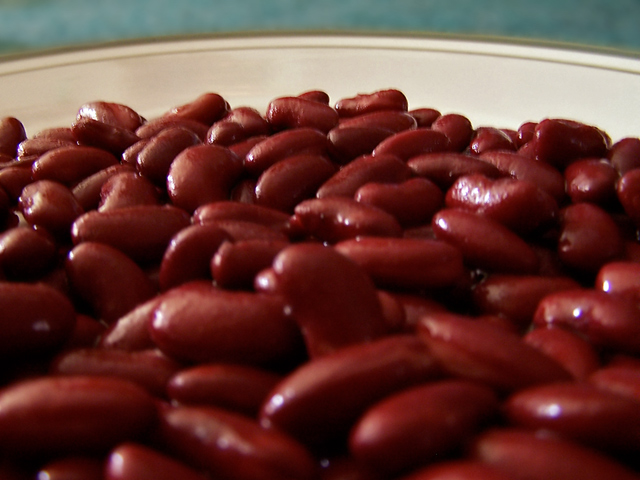


🧩 COLOR_LIGHT
📜 Original:  this is a bit too dark
✨ Retouched: This image is a bit too dark.

🧩 COMPOSITION
📜 Original:  nice composition and i like the colors and the background is a little distracting
✨ Retouched: The composition is nice, and I like the colors, though the background is a little distracting.

🧩 DOF_AND_FOCUS
📜 Original:  i like the colors and the light is a little soft
✨ Retouched: I appreciate the colors, but the lighting is a bit soft.

🧩 GENERAL_IMPRESSION
📜 Original:  i like the colors in this photo great job
✨ Retouched: I really like the colors in this photo; great job!

🧩 SUBJECT
📜 Original:  this is a nice shot
✨ Retouched: This is a lovely shot.

🧩 USE_OF_CAMERA
📜 Original:  all looks on the lighting
✨ Retouched: The lighting looks good overall.

🔍 952321.jpg


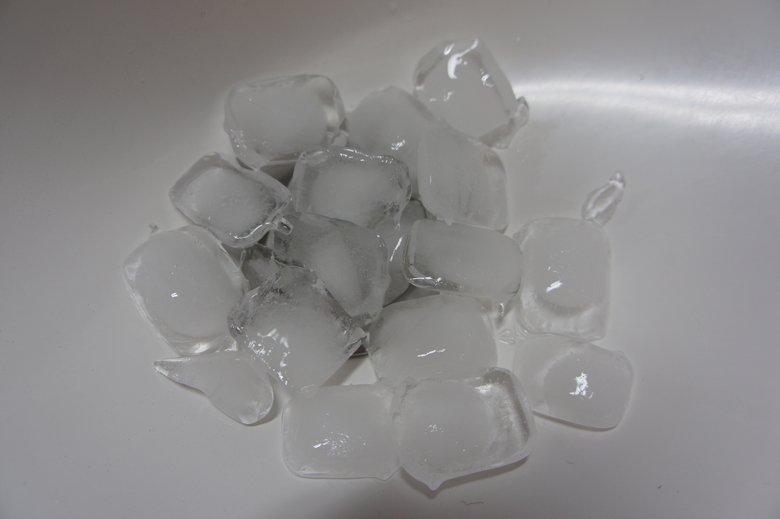


🧩 COLOR_LIGHT
📜 Original:  excellent lighting and dof
✨ Retouched: Excellent lighting and depth of field.

🧩 COMPOSITION
📜 Original:  nice composition and composition good composition
✨ Retouched: Nice composition and arrangement.

🧩 DOF_AND_FOCUS
📜 Original:  seems a little soft focus
✨ Retouched: The focus seems a little soft.

🧩 GENERAL_IMPRESSION
📜 Original:  a very nice picture but i like the idea
✨ Retouched: A very nice picture; I like the concept.

🧩 SUBJECT
📜 Original:  nice still life i like the <unk> of the glass
✨ Retouched: Nice still life; I like the arrangement of the glass.

🧩 USE_OF_CAMERA
📜 Original:  i like the something like something
✨ Retouched: I like the clarity and detail in the image.

🔍 135258.jpg


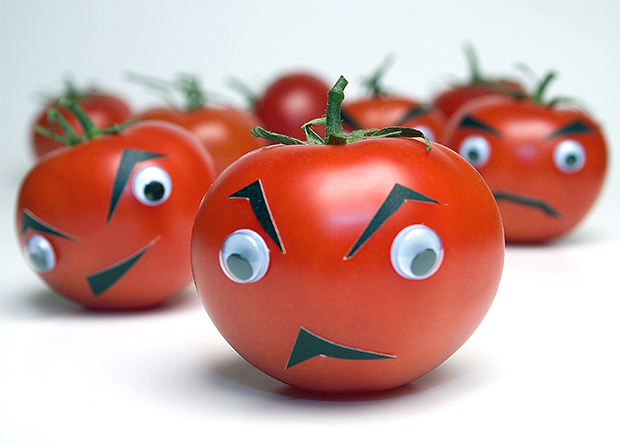


🧩 COLOR_LIGHT
📜 Original:  i like the lighting is a bit harsh
✨ Retouched: I think the lighting is a bit harsh.

🧩 COMPOSITION
📜 Original:  nice composition and lighting is a little distracting
✨ Retouched: The composition is nice, but the lighting is a little distracting.

🧩 DOF_AND_FOCUS
📜 Original:  this image is a little too much of this image is a little dark for me
✨ Retouched: This image is a bit too dark for me.

🧩 GENERAL_IMPRESSION
📜 Original:  good idea and well done
✨ Retouched: It's a good idea and well done.

🧩 SUBJECT
📜 Original:  very nice still life i like the colors are very nice shot
✨ Retouched: This still life is very nice; I like the colors and the shot is well executed.

🧩 USE_OF_CAMERA
📜 Original:  i like something like the <unk> of the <unk> <unk> <unk>
✨ Retouched: I like the use of the depth of field in this playful arrangement of tomatoes.

🔍 278457.jpg


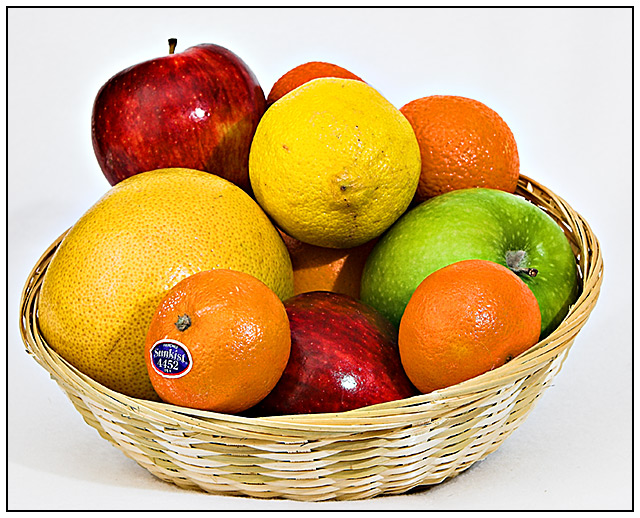


🧩 COLOR_LIGHT
📜 Original:  very nice lighting and colors are a bit harsh
✨ Retouched: The lighting and colors are very nice, although they can be a bit harsh.

🧩 COMPOSITION
📜 Original:  i like the composition and the composition is a little distracting
✨ Retouched: I like the composition, but it is somewhat distracting.

🧩 DOF_AND_FOCUS
📜 Original:  i like the idea of this image would have been better if you were in focus
✨ Retouched: I appreciate the concept of this image; it would have been better if the subject were in focus.

🧩 GENERAL_IMPRESSION
📜 Original:  a good idea but i like the idea
✨ Retouched: It's a good idea, but I really like the concept.

🧩 SUBJECT
📜 Original:  i like the colors on the subject
✨ Retouched: I love the colors of the subject.

🧩 USE_OF_CAMERA
📜 Original:  i like the the <unk> and the <unk> and something
✨ Retouched: I like the use of depth of field and the overall arrangement of the fruits.

🔍 747072.jpg


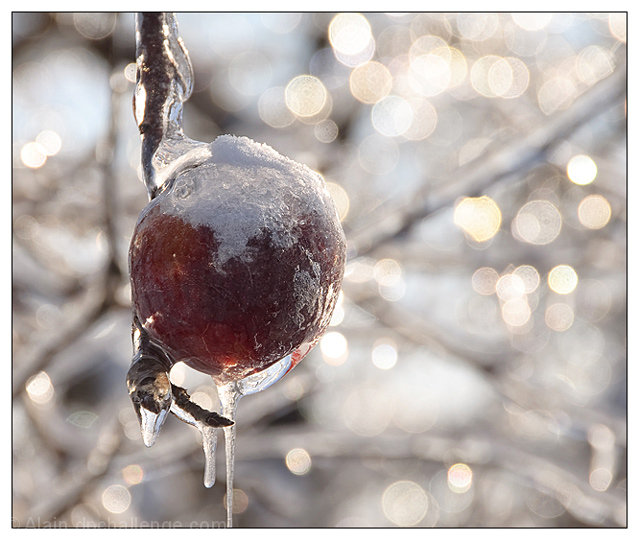


🧩 COLOR_LIGHT
📜 Original:  the lighting is a bit harsh
✨ Retouched: The lighting is a bit harsh.

🧩 COMPOSITION
📜 Original:  i like this shot i like the colors and composition
✨ Retouched: I like this shot; the colors and composition are great.

🧩 DOF_AND_FOCUS
📜 Original:  nice colors and the focus is a little soft focus
✨ Retouched: The colors are nice, but the focus is a little soft.

🧩 GENERAL_IMPRESSION
📜 Original:  nice idea i like the lighting and the background is a bit distracting
✨ Retouched: It's a nice idea; I like the lighting, but the background is somewhat distracting.

🧩 SUBJECT
📜 Original:  the subject is nice shot but i like the top of the glass
✨ Retouched: The subject is a nice shot, but I prefer the top of the glass.

🧩 USE_OF_CAMERA
📜 Original:  this is something like something in the challenge
✨ Retouched: This resembles something from the challenge.

🔍 764591.jpg


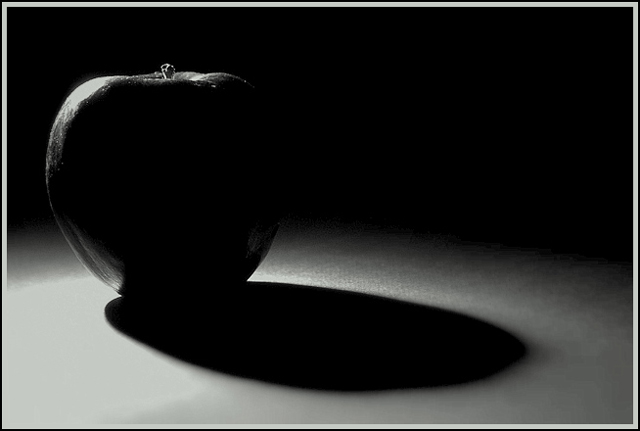


🧩 COLOR_LIGHT
📜 Original:  great use of the <unk>
✨ Retouched: Great use of the lighting.

🧩 COMPOSITION
📜 Original:  nice composition and i like the composition
✨ Retouched: Nice composition; I really like it.

🧩 DOF_AND_FOCUS
📜 Original:  nice job
✨ Retouched: Good job on the focus.

🧩 GENERAL_IMPRESSION
📜 Original:  i love this photo is a nice idea but i would have liked to see a little more of focus
✨ Retouched: I love this photo; it's a nice idea, but I would have preferred a bit more focus.

🧩 SUBJECT
📜 Original:  i would have been better if it would have been a bit more of the glass
✨ Retouched: It would have been better if there were more of the apple visible.

🧩 USE_OF_CAMERA
📜 Original:  this is something like something like the camera in the challenge
✨ Retouched: This resembles the style used in the challenge.

🔍 803166.jpg


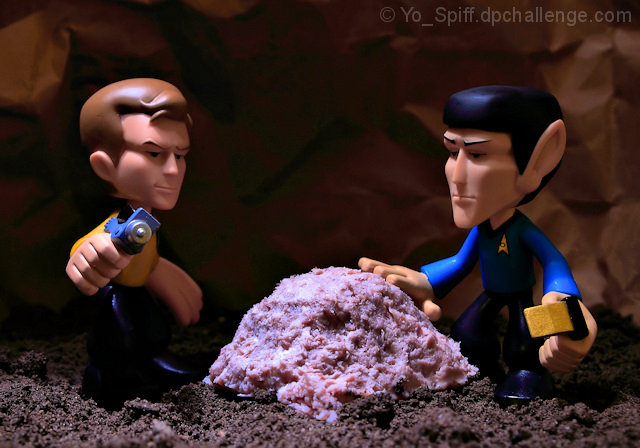


🧩 COLOR_LIGHT
📜 Original:  good use of dof i like the lighting is a bit harsh
✨ Retouched: Good use of depth of field; I like the lighting, although it is a bit harsh.

🧩 COMPOSITION
📜 Original:  this is a lot of interest in this shot i think this would have been better on the top left corner of the left of the
✨ Retouched: There is a lot of interest in this shot; I think it would have been better with the subject in the top left corner.

🧩 DOF_AND_FOCUS
📜 Original:  i like this image i like this image
✨ Retouched: I really like this image!

🧩 GENERAL_IMPRESSION
📜 Original:  not sure what this is a great photo
✨ Retouched: I'm not sure what this is, but it’s a great photo.

🧩 SUBJECT
📜 Original:  this is a very nice shot
✨ Retouched: This is a very nice shot.

🧩 USE_OF_CAMERA
📜 Original:  i like the camera and the challenge of the challenge of the <unk>
✨ Retouched: I appreciate the camera work and the challenge of the scene.

🔍 926965.jpg


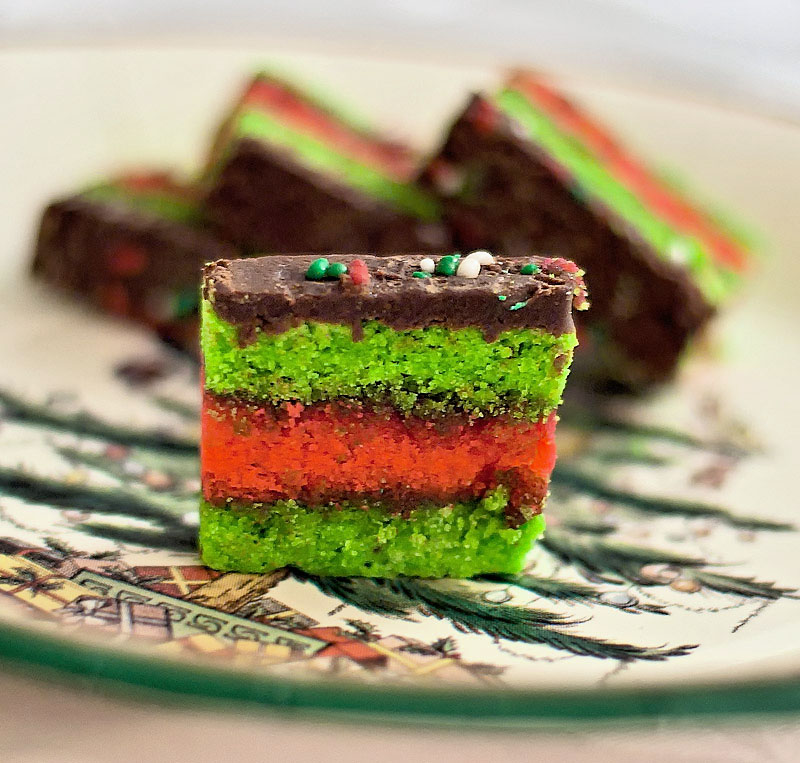

❌ GPT ERROR: Error code: 400 - {'error': {'message': 'You uploaded an unsupported image. Please make sure your image is valid.', 'type': 'invalid_request_error', 'param': None, 'code': 'image_parse_error'}}

🧩 COLOR_LIGHT
📜 Original:  nice use of dof but i think the lighting is a bit harsh on the left side is a bit distracting
✨ Retouched: [GPT ERROR]

🧩 COMPOSITION
📜 Original:  i think this would have been better if the background is a little distracting
✨ Retouched: [GPT ERROR]

🧩 DOF_AND_FOCUS
📜 Original:  i love the colors and the focus is a little too much of focus
✨ Retouched: [GPT ERROR]

🧩 GENERAL_IMPRESSION
📜 Original:  i like the idea but i think this would have been better if it would have been better if this is a great photo
✨ Retouched: [GPT ERROR]

🧩 SUBJECT
📜 Original:  very nice detail and the subject
✨ Retouched: [GPT ERROR]

🧩 USE_OF_CAMERA
📜 Original:  i like something like the camera and the challenge of the challenge of the challenge of the <unk>
✨ Retouched: [GPT 

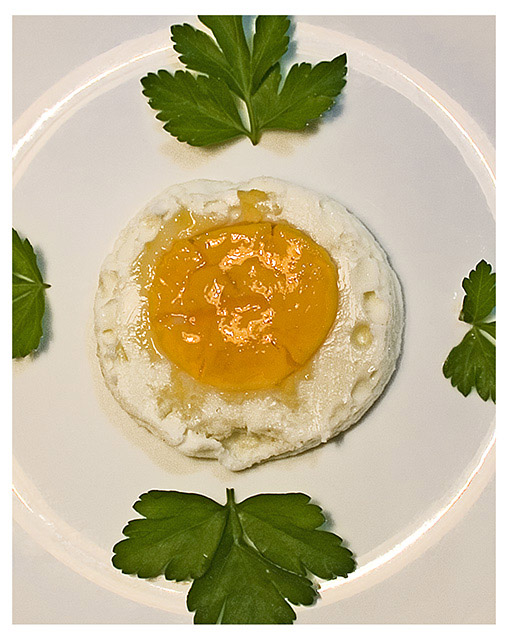


🧩 COLOR_LIGHT
📜 Original:  this is a bit too dark and focus
✨ Retouched: This image is a bit too dark and out of focus.

🧩 COMPOSITION
📜 Original:  i like the composition is a little distracting
✨ Retouched: I like the composition, but it is a little distracting.

🧩 DOF_AND_FOCUS
📜 Original:  this image is a little too much for me but it is a little too much of focus on the bottom of the image is too
✨ Retouched: This image is a bit overwhelming for me, particularly with the focus on the bottom.

🧩 GENERAL_IMPRESSION
📜 Original:  i like the idea but i like the idea but i like the idea
✨ Retouched: I like the idea, but it could be executed better.

🧩 SUBJECT
📜 Original:  is a good shot
✨ Retouched: This is a good shot.

🧩 USE_OF_CAMERA
📜 Original:  i like the <unk> in the challenge of the <unk>
✨ Retouched: I appreciate the challenge of capturing the details in this dish.

🔍 959919.jpg


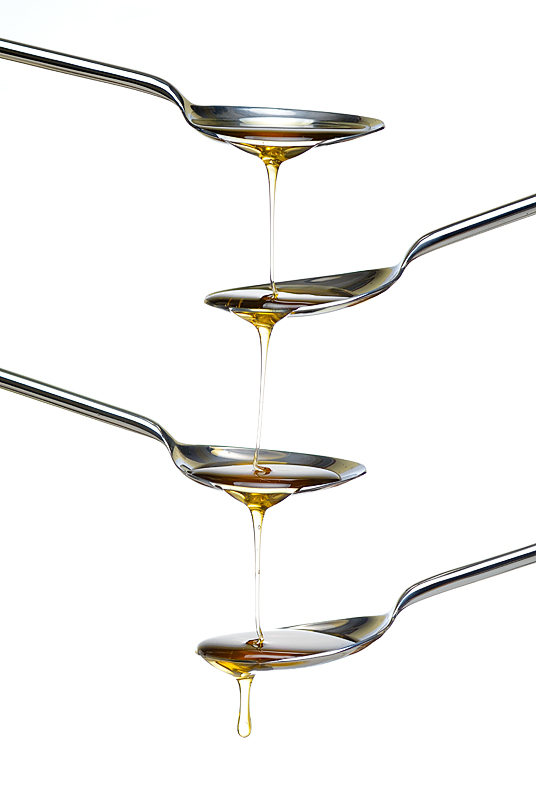


🧩 COLOR_LIGHT
📜 Original:  meets challenge technicalities interestingness out of the box personal bias total
✨ Retouched: The combination of colors is interesting and adds a unique touch to the image.

🧩 COMPOSITION
📜 Original:  i like this shot i like the composition
✨ Retouched: I like this shot; the composition is well done.

🧩 DOF_AND_FOCUS
📜 Original:  i like the idea of the image
✨ Retouched: I appreciate the idea behind this image.

🧩 GENERAL_IMPRESSION
📜 Original:  nice idea but i think it would have been better if it was a good idea
✨ Retouched: It's a nice concept, but I think it could be improved with a stronger execution.

🧩 SUBJECT
📜 Original:  this is a good shot i like the colors and the glass is very nice shot
✨ Retouched: This is a great shot; I love the colors, and the glass looks fantastic.

🧩 USE_OF_CAMERA
📜 Original:  this is something like this is something in the i like the camera and the camera
✨ Retouched: This image showcases the use of camera techniques very

In [16]:
import time, json, os, base64
from IPython.display import display, Image as IPyImage

# --- CONFIG ---
output_file = "/kaggle/working/retouched_batch10.jsonl"
max_images = 10  # jumlah gambar

# --- HELPER ---
def image_to_base64(image_path):
    try:
        with open(image_path, "rb") as img_file:
            return base64.b64encode(img_file.read()).decode("utf-8")
    except Exception as e:
        print(f"⚠️ Could not encode image {image_path}: {e}")
        return None

def build_batch_prompt(aspect_captions, image_base64):
    aspect_text = "\n".join([f"{i+1}. ({asp}) {cap}" for i, (asp, cap) in enumerate(aspect_captions.items())])
    return [
        {
            "role": "system",
            "content": "You are a professional food photography critic. Your job is to revise multiple machine-generated captions for a food image to be fluent, descriptive, and natural."
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"""The following captions were generated by a machine. They may contain <unk> tokens or unnatural phrasing.

Your job:
- Fix grammar and punctuation.
- Replace <unk> using the image for reference.
- Keep original intent.
- Return the 6 improved captions **as a numbered list**, in the same order.

CAPTIONS:
{aspect_text}"""
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}
                }
            ]
        }
    ]

# --- RETOUCH FUNCTION ---
def retouch_batch_captions(image_path, aspect_captions):
    base64_image = image_to_base64(image_path)
    if not base64_image:
        print(f"⚠️ Skipping image {image_path}")
        return {asp: "[IMAGE ERROR]" for asp in aspect_captions}

    try:
        messages = build_batch_prompt(aspect_captions, base64_image)
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            max_tokens=400,
            temperature=0.7
        )
        lines = response.choices[0].message.content.strip().split("\n")
        retouched = {}
        for i, (aspect, _) in enumerate(aspect_captions.items()):
            for line in lines:
                if line.strip().startswith(f"{i+1}."):
                    retouched[aspect] = line.strip()[len(f"{i+1}."):].strip(":- ").strip()
                    break
            else:
                retouched[aspect] = "[PARSE ERROR]"
        return retouched

    except RateLimitError:
        print("⚠️ Rate limit hit. Waiting 60s...")
        time.sleep(60)
        return retouch_batch_captions(image_path, aspect_captions)
    except Exception as e:
        print(f"❌ GPT ERROR: {e}")
        return {asp: "[GPT ERROR]" for asp in aspect_captions}

# --- MAIN LOOP ---
counter = 0
for item in sampled_images:
    if counter >= max_images:
        break

    filename = item['filename']
    image_path = os.path.join(image_folder, filename)
    image_tensor = preprocess_image(image_path)

    print(f"\n🔍 {filename}")
    display(IPyImage(filename=image_path))

    aspect_captions = {}
    for aspect in aspects:
        encoder, decoder = load_model_for_aspect(aspect)
        tokens = caption_image_beam_search(encoder, decoder, image_tensor.squeeze(0), word_map)
        caption = " ".join(tokens)
        aspect_captions[aspect] = caption

    retouched = retouch_batch_captions(image_path, aspect_captions)

    for asp in aspects:
        print(f"\n🧩 {asp.upper()}")
        print(f"📜 Original:  {aspect_captions[asp]}")
        print(f"✨ Retouched: {retouched[asp]}")

    with open(output_file, "a") as f:
        json.dump({
            "filename": filename,
            "image_path": image_path,
            "captions": {
                asp: {
                    "original": aspect_captions[asp],
                    "retouched": retouched[asp]
                } for asp in aspects
            }
        }, f)
        f.write("\n")

    counter += 1